In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import os
import random
from pathlib import Path
import logging
from tqdm import tqdm

import pprint
import hdbscan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from capstone.config import CapstoneConfig
from capstone.data_access import DataClass
from capstone.features import Features
from capstone.evaluation import CustomEvaluation
from capstone.utils.constants import (
    TEXT,
    TARGET,
    ORIGINAL_TEXT,
    SPLIT,
    DEVELOP,
    TEST,
    PREDICTION,
    SAVED_MODELS,
    CLUSTER,
    REDUCED_DIMS,
    TARGET_NUMERIC
)

pp = pprint.PrettyPrinter(depth=4)
sns.set_style("darkgrid")
PARENT_PATH = Path(os.getcwd()).parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

seed = 666
random.seed(seed)
np.random.seed(seed);

Load data

In [2]:
config = CapstoneConfig()
config.CURRENT_PATH = PARENT_PATH

data = DataClass(config)
df = data.build()
df.head(3)

,Text,Standard mapping?
0,General Quality System Requirements […] Manage...,"[quality management, quality planning]"
1,General Quality System Requirements […] Manage...,[quality management]
2,General Quality System Requirements […] Manage...,[quality management]


In [3]:
features = Features(config)
df_features = features.build(df)

df_features.head(3)

2022-12-16 16:48:01,613 - capstone.utils.utils - INFO - func:clean took: 3.60 sec
2022-12-16 16:48:02,311 - capstone.utils.utils - INFO - func:fit took: 4.30 sec
2022-12-16 16:48:04,249 - capstone.utils.utils - INFO - func:clean took: 1.94 sec
2022-12-16 16:48:04,520 - capstone.utils.utils - INFO - func:transform took: 2.21 sec
2022-12-16 16:48:04,521 - capstone.utils.utils - INFO - func:fit_transform took: 6.51 sec
2022-12-16 16:48:04,755 - capstone.utils.utils - INFO - func:clean took: 0.23 sec
2022-12-16 16:48:04,789 - capstone.utils.utils - INFO - func:transform took: 0.27 sec
2022-12-16 16:48:04,838 - capstone.utils.utils - INFO - func:build took: 6.84 sec


,Text,Standard mapping?,Original Text,audit inspection,calibration,capa,change controls,clinical research,controled substances,csv,...,word__unit generally,word__unit generally shared,word__use device,word__used manufacture,word__used production,word__validation study,word__way ensures,word__wholesale distributor,word__written procedure,Split
0,good practice quality control qc responsibilit...,"[laboratory controls, stability programs]",Good practices in quality control […] Other QC...,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.439675,Development
1,good practice quality control basic requiremen...,"[capa, nc, rca]",Good practices in quality control […] The basi...,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,Development
2,validation process validation program critical...,[process & packaging validation],Validation […] Process Validation Program […] ...,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.285952,0.0,0.0,0.000000,Development


In [4]:
# Reduce to test dataset
# df_features = df_features[df_features[SPLIT].isin([TEST])]
# Reduce to single-topic regulations
df_features = df_features[df_features[TARGET].apply(lambda x: len(x)) == 1].copy()
df_features.reset_index(drop=True, inplace=True)

In [5]:
# Custom evaluation class
eval = CustomEvaluation()

Topics to choose from for clustering

We want to remove those topics having count less than some threshold

In [6]:
df_features[TARGET].apply(lambda x: x[0]).value_counts()

production process controls                388
clinical research                          257
labeling and packaging operations          225
non clinical research                      174
data management                            148
purchasing controls                        144
material and product controls              139
risk management                            119
quality management                          99
design controls                             92
laboratory controls                         87
documentation management                    81
stability programs                          81
udi and serialization                       68
vigilance                                   66
qrb                                         59
training                                    54
samd                                        54
audit inspection                            52
medical device post market surveillance     48
controled substances                        46
process & pac

Set the `threshold` and filter out topics having counts less than `threshold`

In [7]:
value_counts = dict(df_features[TARGET].apply(lambda x: x[0]).value_counts())

lower_bound = 40
upper_bound = 60
keep_topics = {label for label in value_counts if value_counts[label] >= lower_bound and value_counts[label] <= upper_bound}
print(f"# Topics: {len(keep_topics)}")

for topic in keep_topics:
    assert topic in features.mlb.classes_

def ifkeep(target, keep_topics):
    for y in target:
        if y not in keep_topics:
            return False
    return True

filter = df_features[TARGET].apply(ifkeep, keep_topics=keep_topics)

# Topics: 8


# Evaluate Embeddings

## Model 1. Ada

Get embeddings

In [25]:
EMBEDDINGS = "embeddings"

embeddings_path = os.path.join(data.reports_path, "ada-embeddings.pkl")
embeddings = pd.read_pickle(embeddings_path)

embeddings = pd.DataFrame(embeddings.items(), columns=[ORIGINAL_TEXT, EMBEDDINGS])
embeddings[ORIGINAL_TEXT] = embeddings[ORIGINAL_TEXT].apply(lambda x: x[0])

embeddings = pd.merge(df_features, embeddings, on=ORIGINAL_TEXT)

regulations = embeddings[ORIGINAL_TEXT].values
y_true = np.argmax(embeddings[features.mlb.classes_].to_numpy(), axis=1)
embeddings = np.stack(embeddings[EMBEDDINGS].values)

embeddings.shape

(2787, 1024)

#### k-Means (Floyd)

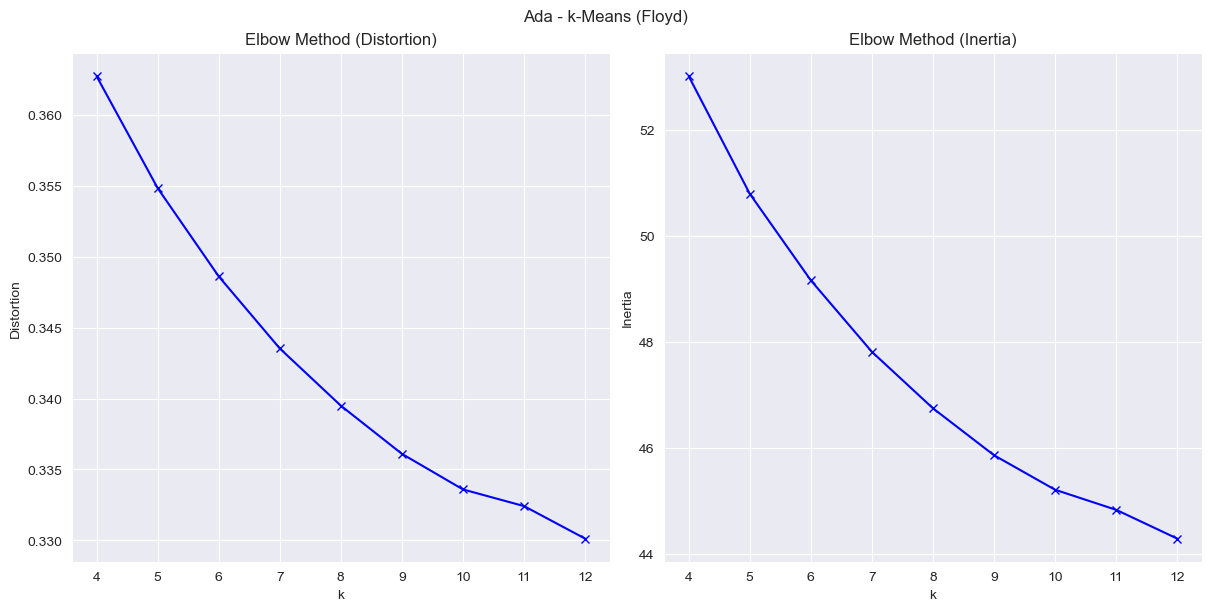

In [26]:
k_values=list(range(len(keep_topics)//2, len(keep_topics)+5))
distortions, inertias = \
    eval.elbow_method(embeddings=embeddings[filter], k_values=k_values)

fig, ax = plt.subplots(1, 2, figsize=(12,6), constrained_layout=True)
ax[0].plot(k_values, distortions, 'bx-')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Distortion')
ax[0].set_title('Elbow Method (Distortion)')
ax[1].plot(k_values, inertias, 'bx-')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Inertia')
ax[1].set_title('Elbow Method (Inertia)')
fig.suptitle("Ada - k-Means (Floyd)");

Purity Scores

In [27]:
k = len(keep_topics)
clusters = KMeans(n_clusters=k, random_state=0).fit(embeddings[filter])

purity_scores, missing, multiple = \
    eval.compute_purity_scores(
        clusters=clusters.labels_,
        y_true=y_true[filter],
        topics=keep_topics,
        features=features
    )
purity_scores

,First Majority,Second Majority,Assigned Cluster
0,"(audit inspection, 0.925)","(medical device post market surveillance, 0.025)",1
1,"(change controls, 0.851)","(process & packaging validation, 0.0638)",6
2,"(controled substances, 0.978)","(qrb, 0.0222)",4
3,"(medical device post market surveillance, 0.694)","(audit inspection, 0.21)",7
4,"(process & packaging validation, 0.947)","(qrb, 0.0263)",2
5,"(qrb, 0.981)","(controled substances, 0.0185)",0
6,"(samd, 0.962)","(medical device post market surveillance, 0.0192)",5
7,"(training, 0.864)","(process & packaging validation, 0.0508)",3


Check for missing/repeating topics

In [28]:
print("\tMissing:")
if not len(missing):
    print("No missing topics")
else:
    pp.pprint(missing)

print("\n\tMultiple:")
if not len(multiple):
    print("No repeating topics")
else:
    pp.pprint(multiple)

	Missing:
No missing topics

	Multiple:
No repeating topics


Visualize

In [29]:
EMBEDDINGS = [f"llm_{i}" for i in range(embeddings.shape[1])]

embeddings_reduced = \
    TSNE(
        n_components=2, init="random", learning_rate="auto", random_state=0
    ).fit_transform(embeddings[filter])

embeddings_df = pd.DataFrame(embeddings[filter], columns=EMBEDDINGS)
embeddings_df[REDUCED_DIMS] = embeddings_reduced
embeddings_df[CLUSTER] = clusters.labels_
embeddings_df[TARGET] = [features.mlb.classes_[c] for c in y_true[filter]]
embeddings_df[ORIGINAL_TEXT] = regulations[filter]
embeddings_df[ORIGINAL_TEXT] = embeddings_df[ORIGINAL_TEXT].str.wrap(100)
embeddings_df[ORIGINAL_TEXT] = embeddings_df[ORIGINAL_TEXT].str.replace("\n", "<br>")

fig = px.scatter(
    embeddings_df,
    y=REDUCED_DIMS[1],
    x=REDUCED_DIMS[0],
    color=CLUSTER,
    symbol=TARGET,
    hover_data=[ORIGINAL_TEXT, TARGET],
    title="Ada with K-Means and TSNE"
)
fig.update_layout(uniformtext_mode="hide")
fig.update_layout(legend_orientation="h")
fig.show()

#### Hierarchical Clustering

Purity Scores

In [30]:
clusters = \
    hdbscan.HDBSCAN(
        min_cluster_size=2,
        metric="euclidean",
        cluster_selection_method="eom"
    ).fit(embeddings[filter])

purity_scores, missing, multiple = \
    eval.compute_purity_scores(
        clusters=clusters.labels_,
        y_true=y_true[filter],
        topics=keep_topics,
        features=features
    )
purity_scores

,First Majority,Second Majority,Assigned Cluster
0,"(audit inspection, 0.667)","(medical device post market surveillance, 0.333)",3
1,"(audit inspection, 1.0)","(-1, 0.0)",19
2,"(audit inspection, 0.5)","(training, 0.5)",21
3,"(audit inspection, 1.0)","(-1, 0.0)",25
4,"(audit inspection, 1.0)","(-1, 0.0)",26
5,"(change controls, 1.0)","(-1, 0.0)",10
6,"(change controls, 0.909)","(process & packaging validation, 0.0909)",22
7,"(controled substances, 1.0)","(-1, 0.0)",0
8,"(controled substances, 1.0)","(-1, 0.0)",1
9,"(controled substances, 1.0)","(-1, 0.0)",2


Check for missing/repeating topics

In [31]:
print("\tMissing:")
if not len(missing):
    print("No missing topics")
else:
    pp.pprint(missing)

print("\n\tMultiple:")
if not len(multiple):
    print("No repeating topics")
else:
    pp.pprint(multiple)

num_unclustered = sum(clusters.labels_==-1) / clusters.labels_.shape[0]
print(f"\nUnclustered samples: {num_unclustered*100:.3}%")

	Missing:
No missing topics

	Multiple:
[('controled substances', 4),
 ('audit inspection', 5),
 ('medical device post market surveillance', 4),
 ('samd', 2),
 ('change controls', 2),
 ('qrb', 5),
 ('process & packaging validation', 2),
 ('training', 3)]

Unclustered samples: 49.6%


Visualize

In [32]:
embeddings_df[CLUSTER] = clusters.labels_

fig = px.scatter(
    embeddings_df,
    y=REDUCED_DIMS[1],
    x=REDUCED_DIMS[0],
    color=CLUSTER,
    symbol=TARGET,
    hover_data=[ORIGINAL_TEXT, TARGET],
    title="Ada - HDBSCAN and TSNE"
)
fig.update_layout(uniformtext_mode="hide")
fig.update_layout(legend_orientation="h")
fig.show()

## Model 2. Curie

Get embeddings

In [8]:
EMBEDDINGS = "embeddings"

embeddings_path = os.path.join(data.reports_path, "curie-embeddings.pkl")
embeddings = pd.read_pickle(embeddings_path)

embeddings = pd.DataFrame(embeddings.items(), columns=[ORIGINAL_TEXT, EMBEDDINGS])
embeddings[ORIGINAL_TEXT] = embeddings[ORIGINAL_TEXT].apply(lambda x: x[0])

embeddings = pd.merge(df_features, embeddings, on=ORIGINAL_TEXT)

regulations = embeddings[ORIGINAL_TEXT].values
y_true = np.argmax(embeddings[features.mlb.classes_].to_numpy(), axis=1)
embeddings = np.stack(embeddings[EMBEDDINGS].values)

embeddings.shape

(2787, 4096)

#### k-Means (Floyd)

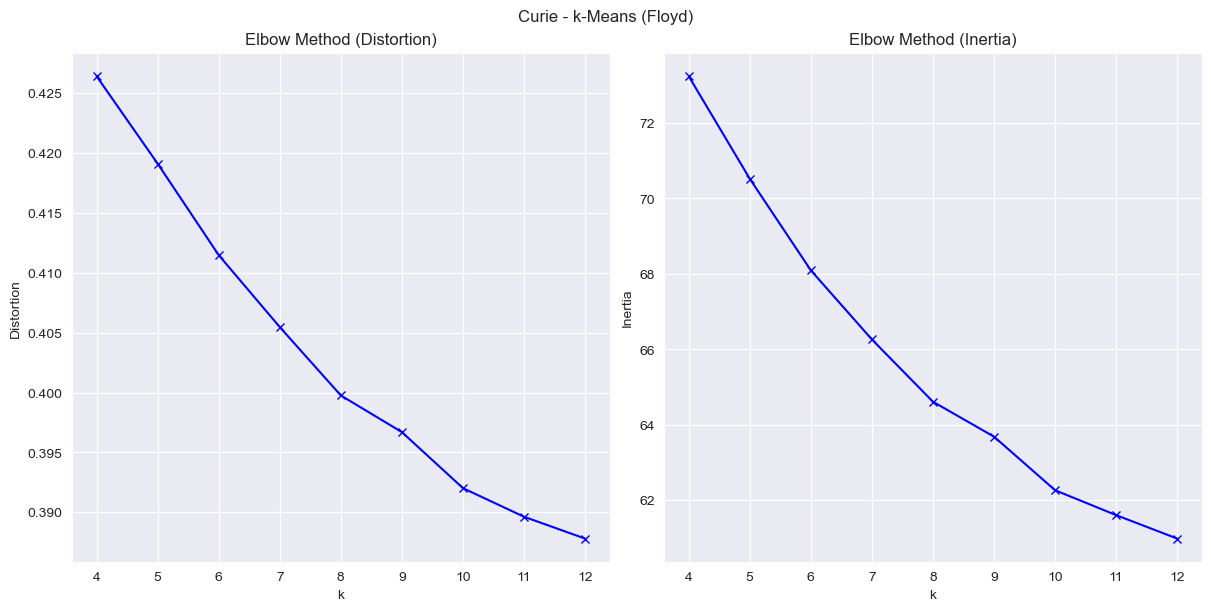

In [16]:
k_values=list(range(len(keep_topics)//2, len(keep_topics)+5))
distortions, inertias = \
    eval.elbow_method(embeddings=embeddings[filter], k_values=k_values)

fig, ax = plt.subplots(1, 2, figsize=(12,6), constrained_layout=True)
ax[0].plot(k_values, distortions, 'bx-')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Distortion')
ax[0].set_title('Elbow Method (Distortion)')
ax[1].plot(k_values, inertias, 'bx-')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Inertia')
ax[1].set_title('Elbow Method (Inertia)')
fig.suptitle("Curie - k-Means (Floyd)");

Purity Scores

In [17]:
k = len(keep_topics)
clusters = KMeans(n_clusters=k, random_state=0).fit(embeddings[filter])

purity_scores, missing, multiple = \
    eval.compute_purity_scores(
        clusters=clusters.labels_,
        y_true=y_true[filter],
        topics=keep_topics,
        features=features
    )
purity_scores

,First Majority,Second Majority,Assigned Cluster
0,"(audit inspection, 0.971)","(process & packaging validation, 0.0286)",2
1,"(change controls, 0.5)","(process & packaging validation, 0.208)",4
2,"(controled substances, 1.0)","(-1, 0.0)",7
3,"(medical device post market surveillance, 0.667)","(audit inspection, 0.19)",0
4,"(process & packaging validation, 0.585)","(change controls, 0.321)",1
5,"(qrb, 1.0)","(-1, 0.0)",5
6,"(samd, 0.98)","(medical device post market surveillance, 0.02)",6
7,"(training, 0.92)","(audit inspection, 0.02)",3


Check for missing/repeating topics

In [18]:
print("\tMissing:")
if not len(missing):
    print("No missing topics")
else:
    pp.pprint(missing)

print("\n\tMultiple:")
if not len(multiple):
    print("No repeating topics")
else:
    pp.pprint(multiple)

	Missing:
No missing topics

	Multiple:
No repeating topics


Visualize

In [19]:
EMBEDDINGS = [f"llm_{i}" for i in range(embeddings.shape[1])]

embeddings_reduced = \
    TSNE(
        n_components=2, init="random", learning_rate="auto", random_state=0
    ).fit_transform(embeddings[filter])

embeddings_df = pd.DataFrame(embeddings[filter], columns=EMBEDDINGS)
embeddings_df[REDUCED_DIMS] = embeddings_reduced
embeddings_df[CLUSTER] = clusters.labels_
embeddings_df[TARGET] = [features.mlb.classes_[c] for c in y_true[filter]]
embeddings_df[ORIGINAL_TEXT] = regulations[filter]
embeddings_df[ORIGINAL_TEXT] = embeddings_df[ORIGINAL_TEXT].str.wrap(100)
embeddings_df[ORIGINAL_TEXT] = embeddings_df[ORIGINAL_TEXT].str.replace("\n", "<br>")

fig = px.scatter(
    embeddings_df,
    y=REDUCED_DIMS[1],
    x=REDUCED_DIMS[0],
    color=CLUSTER,
    symbol=TARGET,
    hover_data=[ORIGINAL_TEXT, TARGET],
    title="Curie with K-Means and TSNE"
)
fig.update_layout(uniformtext_mode="hide")
fig.update_layout(legend_orientation="h")
fig.show()

#### Hierarchical Clustering

Purity Scores

In [20]:
clusters = \
    hdbscan.HDBSCAN(
        min_cluster_size=2,
        metric="euclidean",
        cluster_selection_method="eom"
    ).fit(embeddings[filter])

purity_scores, missing, multiple = \
    eval.compute_purity_scores(
        clusters=clusters.labels_,
        y_true=y_true[filter],
        topics=keep_topics,
        features=features
    )
purity_scores

,First Majority,Second Majority,Assigned Cluster
0,"(audit inspection, 0.5)","(training, 0.5)",3
1,"(audit inspection, 1.0)","(-1, 0.0)",10
2,"(audit inspection, 0.5)","(change controls, 0.31)",22
3,"(change controls, 1.0)","(-1, 0.0)",5
4,"(change controls, 1.0)","(-1, 0.0)",13
5,"(controled substances, 1.0)","(-1, 0.0)",0
6,"(controled substances, 1.0)","(-1, 0.0)",1
7,"(controled substances, 1.0)","(-1, 0.0)",2
8,"(controled substances, 1.0)","(-1, 0.0)",4
9,"(medical device post market surveillance, 1.0)","(-1, 0.0)",8


Check for missing/repeating topics

In [21]:
print("\tMissing:")
if not len(missing):
    print("No missing topics")
else:
    pp.pprint(missing)

print("\n\tMultiple:")
if not len(multiple):
    print("No repeating topics")
else:
    pp.pprint(multiple)

num_unclustered = sum(clusters.labels_==-1) / clusters.labels_.shape[0]
print(f"\nUnclustered samples: {num_unclustered*100:.3}%")

	Missing:
No missing topics

	Multiple:
[('controled substances', 4),
 ('audit inspection', 3),
 ('change controls', 2),
 ('samd', 2),
 ('medical device post market surveillance', 3),
 ('qrb', 4),
 ('process & packaging validation', 4),
 ('training', 4)]

Unclustered samples: 42.3%


Visualize

In [22]:
embeddings_df[CLUSTER] = clusters.labels_

fig = px.scatter(
    embeddings_df,
    y=REDUCED_DIMS[1],
    x=REDUCED_DIMS[0],
    color=CLUSTER,
    symbol=TARGET,
    hover_data=[ORIGINAL_TEXT, TARGET],
    title="Curie - HDBSCAN and TSNE"
)
fig.update_layout(uniformtext_mode="hide")
fig.update_layout(legend_orientation="h")
fig.show()